<h1 style="font-size:40px;"><center>Exercise III:<br> Image Segmentation using CNNs
</center></h1>

## Short summary
In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. The current folder has **three files**: 
- **configSegmenter.py:** this involves definitions of all parameters and data paths
- **utilsSegmenter.py:** includes utility functions required to grab and visualize data 
- **runSegmenter.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras. The very same environment used in Exercise II can be used here as well.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth segmentation images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a CNN model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution |
| 5 | Data | Needed | Data augementation |
| 6 | Data | Needed | Generating the data batches |
| 7 | Debug | Needed | Debugging the data |
| 8 | Device | Needed | Selecting CPU/GPU |
| 9 | Optimization | Exercise 2 | Selecting an optimization method |
| 10 | Training | Exercise 2 | Training the model   |
| 11 | Testing | Exercise 2| Testing the  method   | 
| 13 | Plotting | Information  | View some of test samples |
| 13 | Saving | Information  | Saving the model|


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.
  

1) We first start with importing all required modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from configSegmenter import *
from utilsSegmenter import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import os
import pprint

# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input,  Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout


Using TensorFlow backend.


2) Here, we have the network model class definition. In this class, the most important function is the one called **create_model()**. As defined in the exercises section, your task is to update the network architecture defined in this function such that the network will return the highest accuracy for the given training, validation, and testing data.

In [2]:
 class SegmenterDNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def conv2d_block(self, input_tensor, n_filters, kernel_size=3, batchnorm=True):
        # first layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def create_model(self):

        inputs = Input(shape=self.inputShape)

        down1 = Conv2D(32, (3, 3),padding='same')(inputs)
        down1 = Activation('relu')(down1)
        down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

        down2 = Conv2D(64, (3, 3), padding='same')(down1_pool)
        down2 = Activation('relu')(down2)

        up1 = UpSampling2D((2, 2))(down2)
        up1 = concatenate([down1, up1], axis=3)
        up1 = Conv2D(256, (3, 3), padding='same')(up1)
        up1 = Activation('relu')(up1)

        up2 = Conv2D(256, (3, 3), padding='same')(up1)
        up2 = Activation('relu')(up2)

        classify = Conv2D(self.num_classes, (1, 1), activation='sigmoid')(up2)

        model = Model(inputs=inputs, outputs=classify)
        model.summary()
        return model 
      

3) We import the network **hyperparameters** and build a simple cnn by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configClassifier.py.**. Do not forget to restart kernels. 

In [3]:
cfg = flying_objects_config()
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = SegmenterDNNModel(num_classes=cfg.NUM_CLASS, batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [4]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class triangle 	 3703 images
class circular 	 3626 images
class square 	 3488 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class circular 	 713 images
class triangle 	 745 images
class square 	 783 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We **augment** the data by flipping the image horizontally or vertically. As described in the exercises section below, one of your tasks is to update this data augmentation part in order to increase the network efficiency.

In [5]:
# setup data
if cfg.DATA_AUGMENTATION:
    print("Data is being augmented!")
    aug_parameters = ImageDataGenerator(
        # zoom_range=0.2, # randomly zoom into images
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
else:
    print("Data will not be augmented!")
    aug_parameters = ImageDataGenerator(
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


Data is being augmented!


6) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [6]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_segmentation_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_segmentation_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_segmentation_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
aug_train_batch_generator = generate_augmented_classification_batches(train_batch_generator, aug_parameters)
aug_valid_batch_generator = generate_augmented_classification_batches(valid_batch_generator, aug_parameters)
print("Data batch generators are created!")

Data batch generators are created!


7) We can visualize how the data looks like for debugging purpose

x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0
x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0


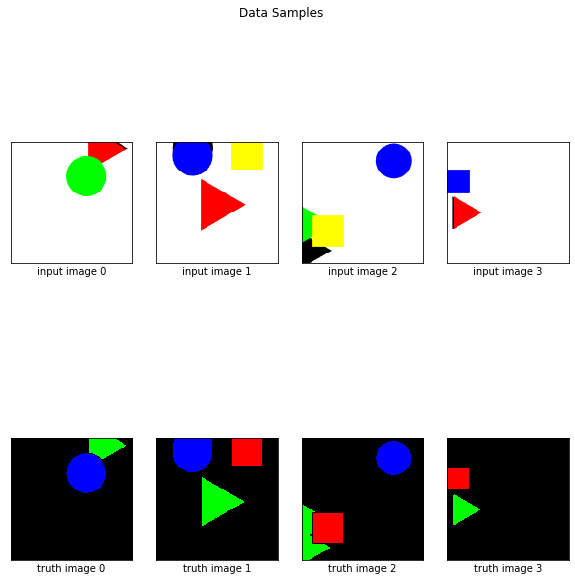

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.5,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'LEARNING_RATE': 0.001,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_CLASS': 4,
 'NUM_EPOCHS': 30,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'fineGrained': False,
 'testing_data_dir': '/data/tmp/data/FlyingObjectDataset_10K/testing/',
 'training_data_dir': '/data/tmp/data/FlyingObjectDataset_10K/training/',
 'validation_data_dir': '/data/tmp/data/FlyingObjectDataset_10K/validation/'}


In [7]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
    a_x, a_y = next(aug_train_batch_generator)
    print('x', a_x.shape, a_x.dtype, a_x.min(), a_x.max())
    print('y', a_y.shape, a_y.dtype, a_y.min(), a_y.max())
    plot_sample_data_with_groundtruth(t_x, t_y)
    pprint.pprint (cfg)

8) We select which processing unit to use, either CPU or GPU. In case of having multiple GPUs, we can still select which GPU to use.

In [8]:
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

creating network model using gpu 0


9) We set the training configuration. As a part of the exercises, this function can also be updated to test different **optimization methods** such as **SGD, ADAM,** etc.

In [9]:
opt = tf.train.AdamOptimizer(cfg.LEARNING_RATE)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= opt, metrics=['accuracy']) 

10) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configSegmenter.py.**

In [11]:
history = model.fit_generator(generator = aug_train_batch_generator,
          epochs=cfg.NUM_EPOCHS,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=aug_valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S")), write_graph=True, write_images=False,
                                 histogram_freq=0)])

Epoch 1/1
338/338 [==============================] - 52s 155ms/step - loss: 0.4841 - acc: 0.8662 - val_loss: 0.5009 - val_acc: 0.8635


11) We can test the model with the test data

In [12]:
# testing model
test_result = model.evaluate_generator(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_acc = round(test_result[1], 4)
print("Test Loss: ", str(test_loss), "Test Accuracy: ", str(test_acc))

Test Loss:  0.2775 Test Accuracy:  0.8847


12) We can also show sample segmentation results

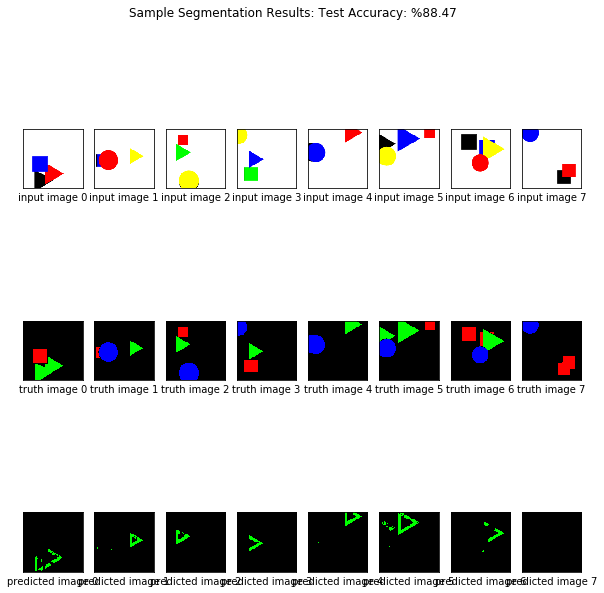

In [13]:
t_data, t_segments = next(test_batch_generator)
pred_segments = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_segmentation_results(t_data, t_segments, pred_segments, test_acc)

13) Finally, we can save the model

In [14]:
# save the model
model.save(str(output_log_dir)+'/model.h5') 

NameError: name 'output_log_dir' is not defined

## EXERCISES

Please do all exercises desribed below. Note that all your source code as well as the log folders must be provided as final results **before May 02, 2019.** 


#### Exercise 1)
Update the network architecture given in the function **create_model** of the class SegmenterDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. batchnorm, dropout) methods to increase the network accuracy. Try adding more skip connections from early encoder layers to deeper decoder layers as well. 

#### Hint:
All network resposes are stored in a **log folder** which is automatically created. To visualize these responses, we can use the tensorboard as follows:
- First make sure that there is a new folder created with **a date and time stamp** under folder **logs**
- Next, open a terminal and type 
    > tensorboard --logdir=./logs
- Finally, open a web browser and type 
    > http://localhost:6006
- You can have an overview of all accuracies on the tensorboard. For more information about tensorboard, please see https://www.tensorflow.org/guide/summaries_and_tensorboard

# The report!


### Name

### Introduction

### Answers to questions

### Summary